In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deepxde
import re

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from matplotlib import cm
import scipy.io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 13.0 MB/s eta 0:00:00
No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



## Safety PDE with data

In [ ]:
import scipy.io

mat = scipy.io.loadmat('/content/drive/MyDrive/RL+PDE/data/observe_x_safety.mat')

obs_x = mat['observe_x']
obs_func = mat['observe_func']

# obs_x.shape # (1500, 3)
# obs_func.shape # (1500, 1)

Text(0.5, 0.92, 'MC')

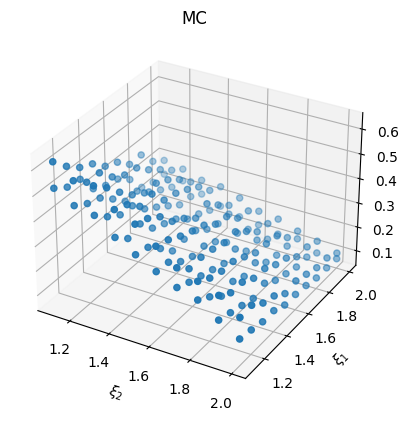

In [ ]:
a = 800
b = 1000

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.scatter(obs_x[a:b,1], obs_x[a:b,0], obs_func[a:b]) # X: time, Y: state
ha.set_xlabel(r'$\xi_2$')
ha.set_ylabel(r'$\xi_1$')
ha.set_title("MC")

In [ ]:
ic = np.mgrid[1:4:0.05, 1:4:0.05, 0:0.1:1].reshape(3,-1).T
ic
ic.shape # (3600, 3)
ic_func = np.ones([3600,1])

bc1 = np.mgrid[4:4.01:0.05, 1:4:0.05, 0:1:0.1].reshape(3,-1).T
bc1
bc1.shape # (600, 3)
bc1_func = np.zeros([600,1])

bc2 = np.mgrid[1:4:0.05, 4:4.01:0.05, 0:1:0.1].reshape(3,-1).T
bc2
bc2.shape # (600, 3)
bc2_func = np.zeros([600,1])

a = 0
b = 500

observe_x = np.append(obs_x[a:b], ic, axis=0)
observe_x = np.append(observe_x, bc1, axis=0)
observe_x = np.append(observe_x, bc2, axis=0)
# observe_x.shape # (9900, 3)
# # observe_x

observe_func = np.append(obs_func[a:b], ic_func, axis=0)
observe_func = np.append(observe_func, bc1_func, axis=0)
observe_func = np.append(observe_func, bc2_func, axis=0)
# observe_func

### Fixed PDE

In [ ]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=2)
    dy_x1 = dde.grad.jacobian(y, x, j=0)
    dy_xx1 = dde.grad.hessian(y, x, i=0)
    dy_x2 = dde.grad.jacobian(y, x, j=1)
    dy_xx2 = dde.grad.hessian(y, x, i=1, j=1)
    # Backend tensorflow.compat.v1 or tensorflow
    return (
        dy_t
        - x[:, 0:1] * dy_x1
        - x[:, 1:2] * dy_x2
        - dy_xx1
        - 0.5 * dy_xx2
    )

### Varying PDE

In [ ]:
observe_y = dde.icbc.PointSetBC(observe_x, observe_func, component=0)

geom = dde.geometry.geometry_2d.Rectangle([1,1],[4,4])
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [observe_y],
    # num_domain=200,
    num_domain=600,
    # num_boundary=20,
    # num_initial=10,
    anchors=observe_x,
)

In [ ]:
layer_size = [3] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile(
    "adam", lr=0.001, external_trainable_variables=[]
)
variable = dde.callbacks.VariableValue([], period=1000)
model.train(epochs=60000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.063652 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.287534 s

Training model...

Step      Train loss              Test loss               Test metric
0         [8.24e-02, 6.75e-01]    [8.24e-02, 6.75e-01]    []  
0 []
1000      [1.72e-03, 3.02e-02]    [1.72e-03, 3.02e-02]    []  
1000 []
2000      [1.09e-03, 1.70e-02]    [1.09e-03, 1.70e-02]    []  
2000 []
3000      [7.61e-04, 1.53e-02]    [7.61e-04, 1.53e-02]    []  
3000 []
4000      [9.54e-04, 1.46e-02]    [9.54e-04, 1.46e-02]    []  
4000 []
5000      [8.18e-04, 1.43e-02]    [8.18e-04, 1.43e-02]    []  
5000 []
6000      [4.89e-04, 1.40e-02]    [4.89e-04, 1.40e-02]    []  
6000 []
7000      [4.71e-04, 1.38e-02]    [4.71e-04, 1.38e-02]    []  
7000 []
8000      [4.48e-04, 1.36e-02]    [4.48e-04, 1.36e-02]    []  
8000 []
9000      [5.30e-04, 1.35e-02]    [5.30e-04, 1.35e-02]    []  
9000 []
10000     [6.20e-04, 1.33e-02]    [6.20e-04, 1.33e-02]    []  
10000 []
11000     [4.17e-04, 1.32e-02]    [4.17e-04, 1.32e-02]    []  
11000 []
12000     [4.16e-04, 1.31e-02]   

(<deepxde.model.LossHistory at 0x7f637c1a69e0>,
 <deepxde.model.TrainState at 0x7f637c1a4970>)

In [ ]:
test_x = obs_x
test_x.shape

yhat = model.predict(test_x)

yhat.shape

difference = yhat - obs_func

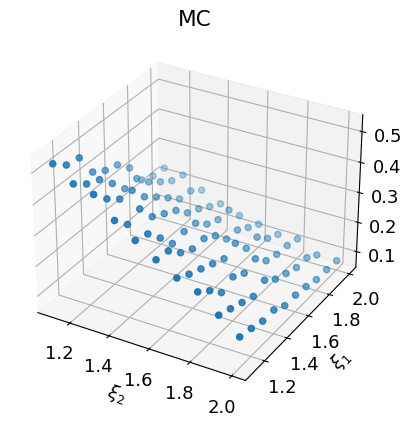

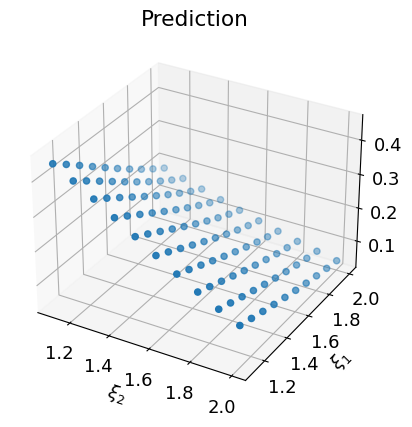

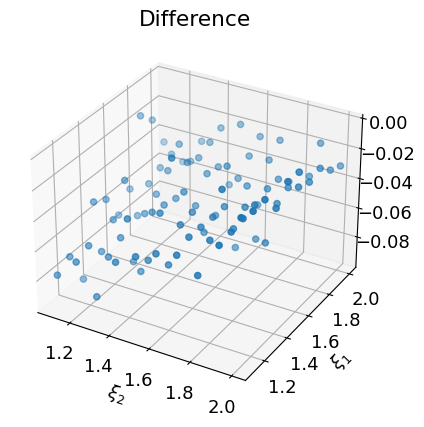

In [ ]:
# the first 2 subplots are used for Figure 4 in the paper

a = 900
b = 1000

import matplotlib
matplotlib.rcParams.update({'font.size': 13})

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.scatter(obs_x[a:b,1], obs_x[a:b,0], obs_func[a:b]) # X: time, Y: state
ha.set_xlabel(r'$\xi_2$')
ha.set_ylabel(r'$\xi_1$')
ha.set_title("MC")
plt.savefig("MC.pdf")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.scatter(obs_x[a:b,1], obs_x[a:b,0], yhat[a:b]) # X: time, Y: state
ha.set_xlabel(r'$\xi_2$')
ha.set_ylabel(r'$\xi_1$')
ha.set_title("Prediction")
plt.savefig("Prediction.pdf")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.scatter(obs_x[a:b,1], obs_x[a:b,0], difference[a:b]) # X: time, Y: state
ha.set_xlabel(r'$\xi_2$')
ha.set_ylabel(r'$\xi_1$')
ha.set_title("Difference")
plt.savefig("Difference.pdf")
plt.show()